# Training the sine wave model

Based on the **hello_world** example from [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).

I removed a lot of the explanations, so if any of this doesn't make sense to you, [refer to the original notebook](https://github.com/tensorflow/tensorflow/blob/e0b19f6ef223af40e2e6d1d21b8464c1b2ebee8f/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb).

Tested with TensorFlow 2.2.0.

# Install TensorFlow if you don't have it yet.
!pip install -q tensorflow==2.2.0

In [5]:
! pip install tensorflow==2.17.0
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

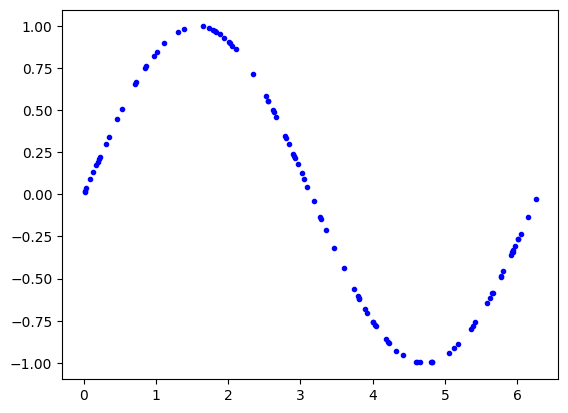

In [16]:
SAMPLES = 100
SEED = 12
np.random.seed(SEED)
tf.random.set_seed(SEED)
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)
np.random.shuffle(x_values)
y_values = np.sin(x_values)
plt.plot(x_values, y_values, 'b.')
plt.show()

In [ ]:
# Set a "seed" value, so we get the same random numbers each time we run this
# notebook for reproducible results.
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

In [ ]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import math

## Dataset

### 1. Generate Data

In [ ]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Add Noise

In [ ]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Split the Data

In [ ]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Training

In [ ]:
# If you don't want to train again, load the trained model.
#model = keras.models.load_model("model.h5")

### 1. Design the Model

In [ ]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second layer may help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model.summary()

### 2. Train the Model ###

In [ ]:
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

### 3. Plot Metrics

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.clf()

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

### 4. Check against test set

In [ ]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
predictions = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Save the trained model just in case we need it again later.
model.save("model.h5")

## NumPy version

Let's see how we can make predictions by hand. If we grab the weights from the layers, we can do the math ourselves.

In [ ]:
W1, b1 = model.layers[0].get_weights()
W2, b2 = model.layers[1].get_weights()
W3, b3 = model.layers[2].get_weights()

In [ ]:
print(W1.shape, b1.shape)
print(W2.shape, b2.shape)
print(W3.shape, b3.shape)

In [ ]:
xs = x_test

In [ ]:
# This is what the TF model does internally:
ys = []
for x in xs:
    x = np.array([x])       # x should be array
    h1 = x @ W1 + b1        # dense layer
    h1 = np.maximum(0, h1)  # ReLU
    h2 = h1 @ W2 + b2       # dense layer
    h2 = np.maximum(0, h2)  # ReLU
    h3 = h2 @ W3 + b3       # dense layer
    ys.append(h3)

ys = np.stack(ys)

In [ ]:
# Are our predictions the same as TF's predictions?
# This should print 0 if the results are close enough.
np.sum(np.abs(ys - predictions) > 1e-6)

## Export the weights

In [ ]:
# Note that we transpose W2. This makes the inner loop for the
# matrix multiplication a little simpler.

names = ["W1_data", "b1_data", "W2_data", "b2_data", "W3_data", "b3_data"]
arrays = [W1, b1, W2.T, b2, W3, b3]

In [ ]:
# Copy this into model_data.cpp:

for name, array in zip(names, arrays):
    print("const float %s[] PROGMEM = {" % name)
    print("   ", ", ".join([str(x) + "f" for x in array.flatten()]))
    print("};\n")